# SetUP

In [1]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/cleanData/")

In [2]:
suppressPackageStartupMessages({
library(dplyr)
library(tidyverse)
library(data.table)
library(ggplot2)
library(edgeR)
library(RColorBrewer)
library(GenomicRanges)
library(ComplexHeatmap)
library(Signac)
#library(rtracklayer)
#library(igraph)
})

# group stripes

In [3]:
Ustripes <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/stripes/res/allhumanBrain_1k_PFC_V1/all.humanBrain.eNtoRG.PFCV1.1k.stripes_20_50_S+L.edgeR.FDR0.05_log2FC0.5.res.Up.larger1Mb")
Dstripes <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/stripes/res/allhumanBrain_1k_PFC_V1/all.humanBrain.eNtoRG.PFCV1.1k.stripes_20_50_S+L.edgeR.FDR0.05_log2FC0.5.res.Down.larger1Mb")
Nstripes <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/stripes/res/allhumanBrain_1k_PFC_V1/all.humanBrain.eNtoRG.PFCV1.1k.stripes_20_50_S+L.edgeR.FDR0.05_log2FC0.5.res.Not.larger1Mb")

In [4]:
Inpt <- rbind(Ustripes,
      Dstripes,
      Nstripes) %>% 
mutate(L=V3-V2,R=V6-V5) %>% 
mutate(Group=case_when(L==50000 | L==20000 ~ "Left",
                       R==50000 | R==20000 ~ "Right")) 

In [5]:
LSA <- Inpt %>% filter(Group=="Left") %>% select(V1,V2,V3) %>% 
set_names("seqnames","start","end") %>% distinct() %>% mutate(start=start+1) %>%
makeGRangesFromDataFrame()
RSA <- Inpt %>% filter(Group=="Right") %>% select(V4,V5,V6) %>% 
set_names("seqnames","start","end") %>%distinct() %>%mutate(start=start+1) %>%
makeGRangesFromDataFrame()

In [6]:
Boundary <- read.table("../analysis/stripes/res/allhumanBrain_1k_PFC_V1//RG.eN.boundary") %>% 
mutate(V2=V2,V3=V3-1) %>% 
set_names("seqnames","start","end") %>%
makeGRangesFromDataFrame()

In [7]:
TAD <- gaps(Boundary) 

In [111]:
Lres <- distanceToNearest(LSA,Boundary) %>% as.data.frame() 
Lr <- LSA[queryHits(distanceToNearest(LSA,Boundary))] %>% as.data.frame() %>% mutate(dis=Lres$distance) %>%
makeGRangesFromDataFrame(.,keep.extra.columns = T)

LSA.RES <- cbind(Lr[queryHits(findOverlaps(Lr,TAD)),] %>% as.data.frame(),
TAD[subjectHits(findOverlaps(Lr,TAD)),] %>% as.data.frame()) %>% 
set_names(paste0("V",1:11)) %>% mutate(dis=V2-V8) %>%
mutate(ratio=case_when(dis*2 <= V10 ~ V6/V10*100,
                       dis*2 > V10 ~ (V10-V6)/V10*100))

In [112]:
Rres <- distanceToNearest(RSA,Boundary) %>% as.data.frame() 
Rr <- RSA[queryHits(distanceToNearest(RSA,Boundary))] %>% as.data.frame() %>% mutate(dis=Rres$distance) %>%
makeGRangesFromDataFrame(.,keep.extra.columns = T)

RSA.RES <- cbind(Rr[queryHits(findOverlaps(Rr,TAD)),] %>% as.data.frame(),
TAD[subjectHits(findOverlaps(Rr,TAD)),] %>% as.data.frame()) %>% 
set_names(paste0("V",1:11)) %>% mutate(dis=V2-V8) %>%
mutate(ratio=case_when(dis*2 <= V10 ~ V6/V10*100,
                       dis*2 > V10 ~ (V10-V6)/V10*100))

In [113]:
plotDF <- cbind(LSA.RES[,13],RSA.RES[,13]) %>% as.data.frame() %>% set_names("5\' stripes \n n = 1646",
                                                                             "3\' stripes \n n = 1845")

Warning message in cbind(...):
“number of rows of result is not a multiple of vector length (arg 1)”


In [116]:
mat = plotDF
options(repr.plot.width=3.3,repr.plot.height=4)
pdf("../FINAL_figures/fig2/humanBrain_1K_PFCV1_RGeN_allSA_larger1Mb_Toboundary.pdf",width=3.3,height=4)
densityHeatmap(mat,col = viridis::turbo(500,direction = 1),show_quantiles = F,
               title = "distance of SAs to DBs",
               ylab = "#of TAD(%)")
dev.off()

png 
  2

In [40]:
plotDF <- rbind(LSA.RES %>% mutate(Group="5\'"),RSA.RES%>% mutate(Group="3\'"))

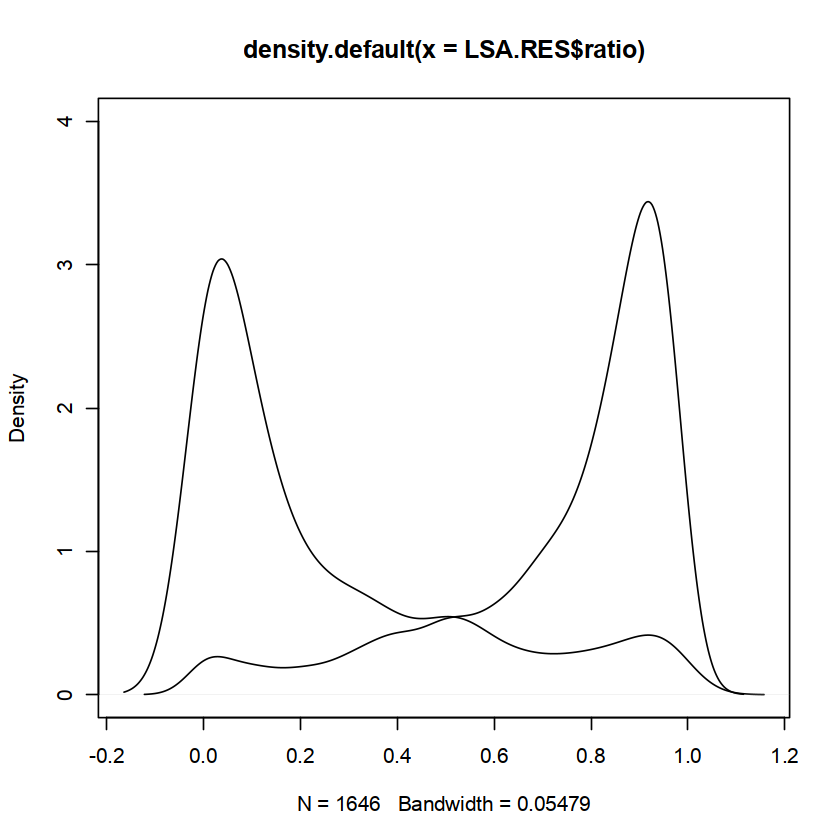

In [29]:
plot(density(LSA.RES$ratio),ylim=c(0,4))
lines(density(RSA.RES$ratio))